In [1]:
!pip install accelerate==0.30.0 tensorflow scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from scikeras.wrappers import KerasClassifier

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer

from accelerate import Accelerator

import torch

In [3]:
import warnings

warnings.simplefilter("ignore")

In [4]:
from google.colab import files
uploaded = files.upload()

Saving twitter_posts_sentiment.csv to twitter_posts_sentiment.csv


In [5]:
twitter_posts = pd.read_csv("twitter_posts_sentiment.csv")
twitter_posts.head(10)

,Sentence,Sentiment
0,you denounce their identity kashmir just becau...,positive
1,want believe modi correct,neutral
2,possibility very high the way research and kno...,positive
3,why need modi lead bjp government again 2019te...,negative
4,groundbreaking announcement congress president...,neutral
5,agree kcr quoting masood azhar unacceptable bu...,negative
6,modi going win full majority and all the oppos...,positive
7,proud our scientist and proud our prime minist...,positive
8,narendra modi failed chowkidar when planes ind...,negative
9,narendra modis blog leader for the ages was ah...,neutral


# Exploratory Data Analysis

In [6]:
twitter_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168811 entries, 0 to 168810
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentence   168811 non-null  object
 1   Sentiment  168811 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB


In [7]:
twitter_posts = twitter_posts.dropna(subset=["Sentiment"])

In [8]:
twitter_posts.isna().sum()

,0
Sentence,0
Sentiment,0


In [9]:
twitter_posts.duplicated().sum()

6

In [10]:
twitter_posts_df = twitter_posts.drop_duplicates()
twitter_posts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168805 entries, 0 to 168810
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentence   168805 non-null  object
 1   Sentiment  168805 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [11]:
twitter_posts_df.sample(10)

,Sentence,Sentiment
128033,with these kind persons the party what would m...,positive
48495,why waste funds inquiry\nmodi has ordered new ...,negative
83836,there difference between doing something drawi...,negative
61744,might resonating not only these states but oth...,positive
22197,personal attacks bjp exactly what modi set sta...,positive
64162,modis new india the hinduthe accused the dadri...,positive
42999,yashodaben more happy without chor chowkidar m...,positive
153606,the man who dons many hats sure loves them too...,positive
15203,you can celebrate congratulations,neutral
155679,what castism its permanent pariwarwad brahman ...,negative


In [12]:
twitter_posts_df["Sentiment"].value_counts()

,count
Sentiment,
positive,74101
neutral,58335
negative,36369


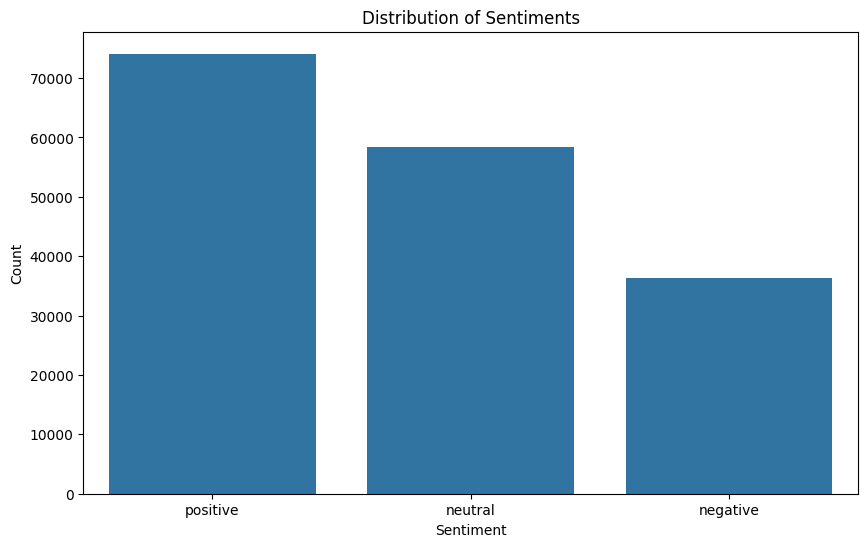

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=twitter_posts_df, x='Sentiment', order=twitter_posts_df['Sentiment'].value_counts().index)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [14]:
twitter_posts_df['text_length'] = twitter_posts_df['Sentence'].apply(len)

In [15]:
twitter_posts_df.head()

,Sentence,Sentiment,text_length
0,you denounce their identity kashmir just becau...,positive,209
1,want believe modi correct,neutral,25
2,possibility very high the way research and kno...,positive,243
3,why need modi lead bjp government again 2019te...,negative,177
4,groundbreaking announcement congress president...,neutral,188


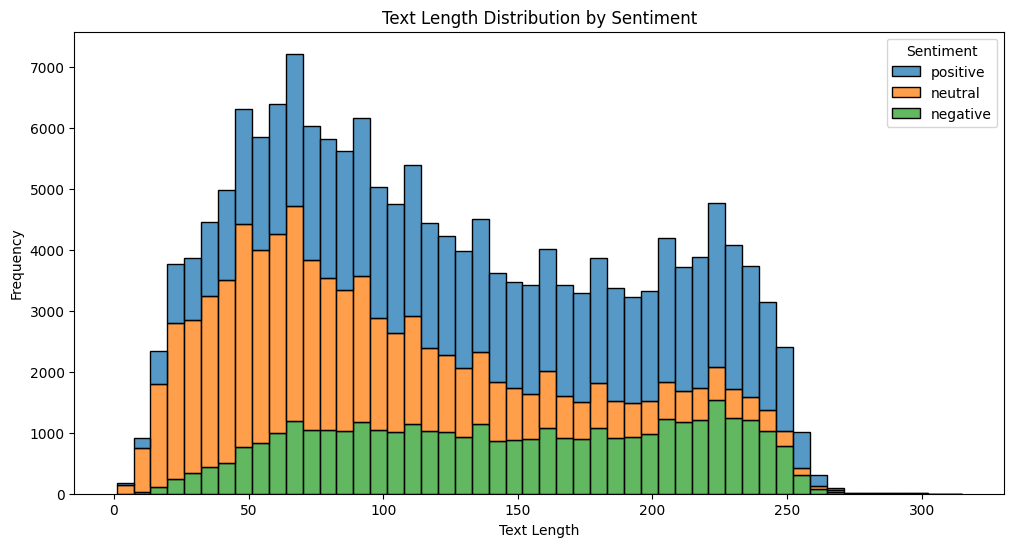

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(data=twitter_posts_df, x='text_length', hue='Sentiment', multiple='stack', bins=50)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

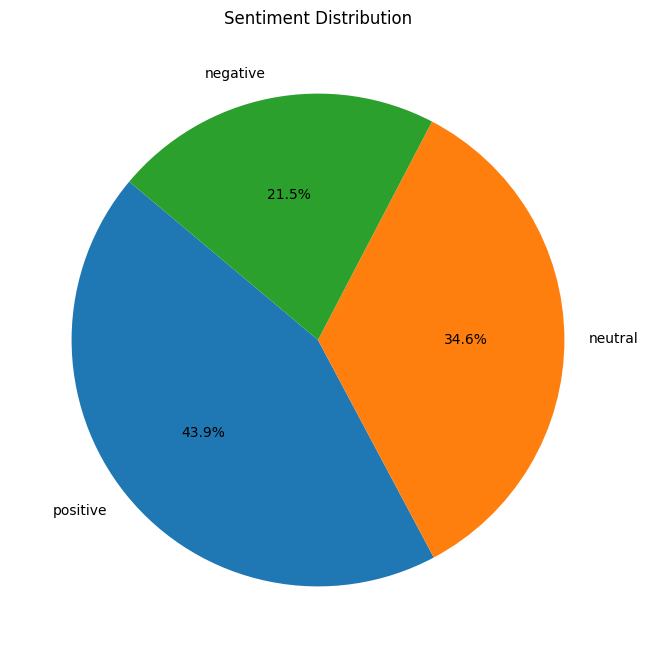

In [18]:
sentiment_counts = twitter_posts_df['Sentiment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.show()

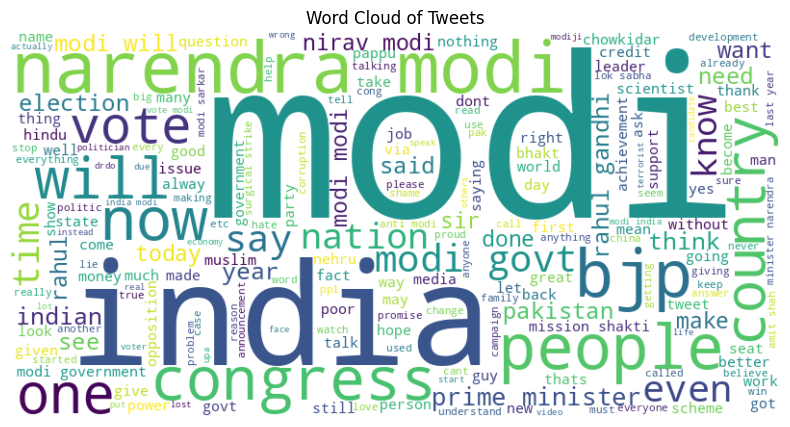

In [19]:
from wordcloud import WordCloud

text = ' '.join(twitter_posts_df['Sentence'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()


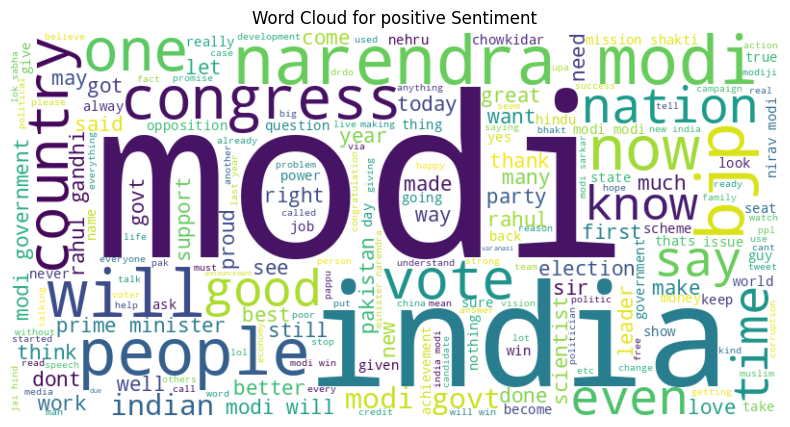

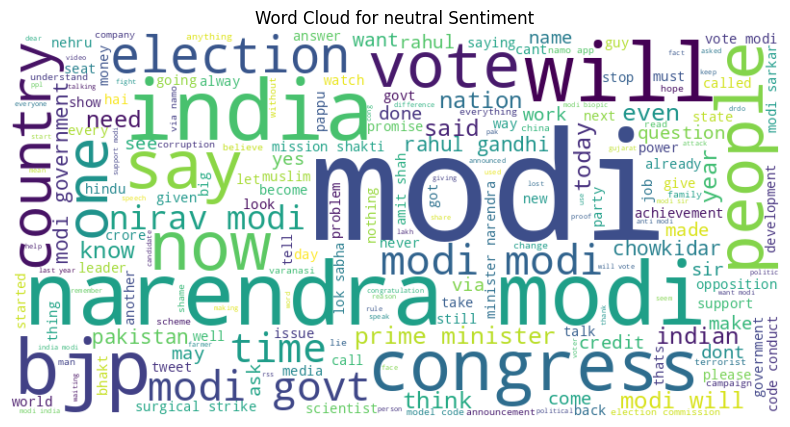

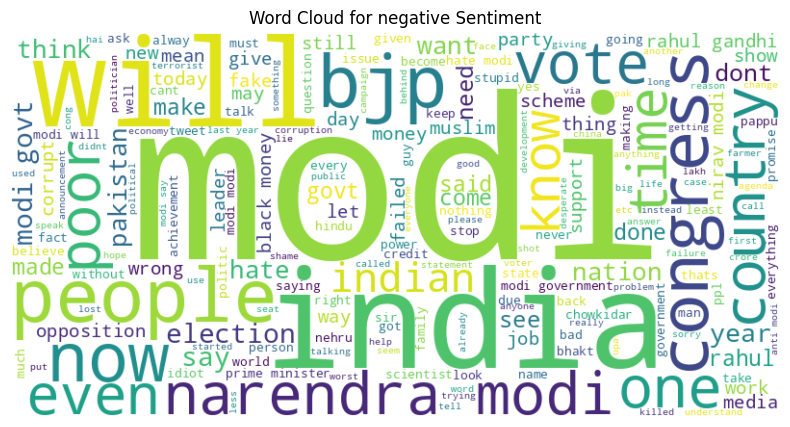

In [20]:
for sentiment in twitter_posts_df['Sentiment'].unique():
    plt.figure(figsize=(10, 5))
    subset = twitter_posts_df[twitter_posts_df['Sentiment'] == sentiment]
    text = ' '.join(subset['Sentence'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()


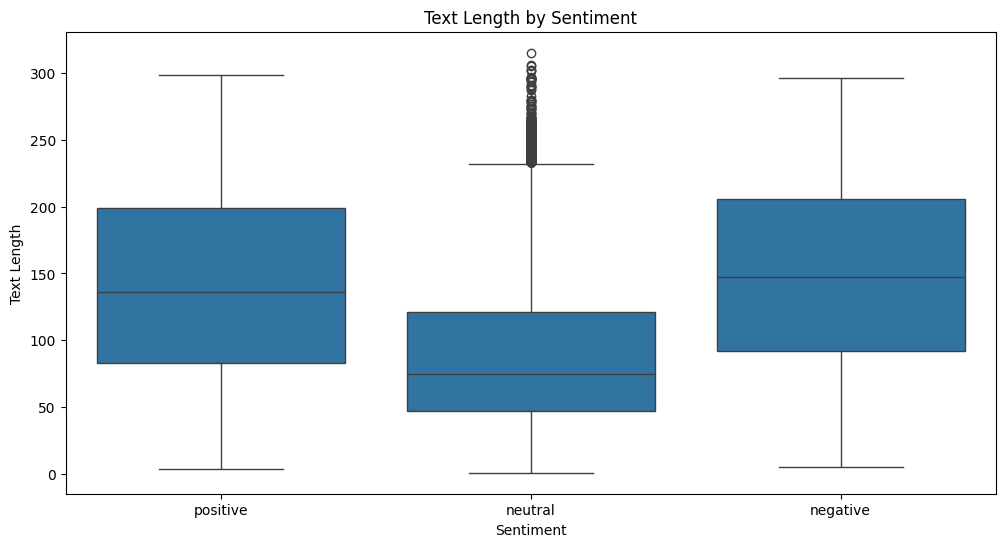

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=twitter_posts_df, x='Sentiment', y='text_length')
plt.title('Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

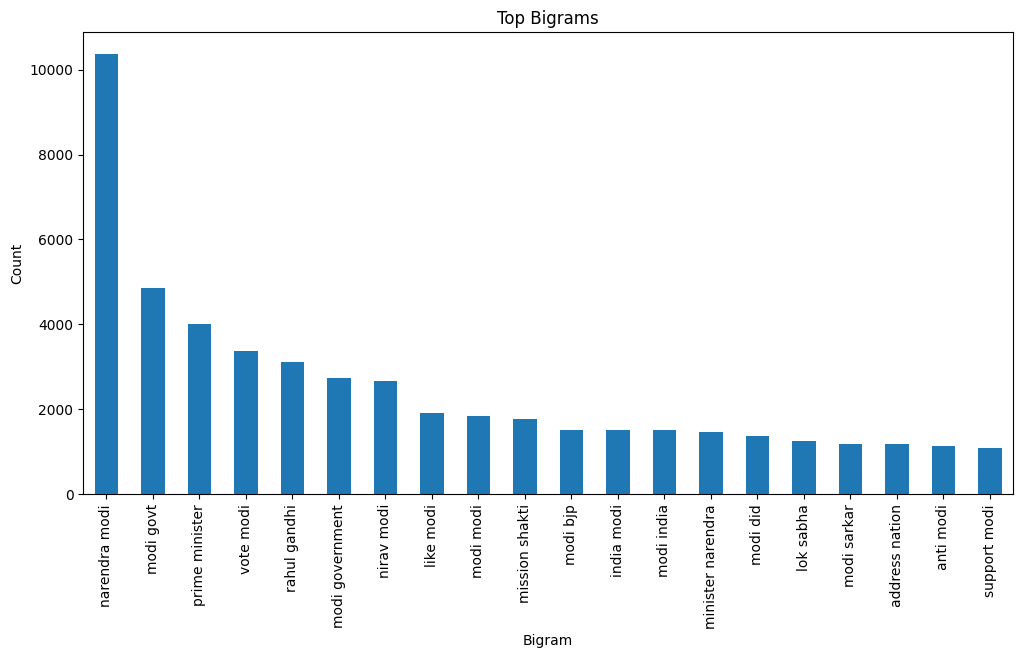

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(twitter_posts_df['Sentence'])
bigrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

bigrams_sum = bigrams.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
bigrams_sum.head(20).plot(kind='bar')
plt.title('Top Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Count')
plt.show()


In [24]:
twitter_posts_df['Sentence'].str.contains(r'[^\w\s]', regex=True).sum()

25057

# Data Pre-processing

In [ ]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.6 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171034 sha256=c86bd0df6d0a1aa77e457e1978eff017264bcbcbcffda4ffbd1bd097d0132c77
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [ ]:
!pip install Unicode

In [ ]:
from cleantext import clean


def text_cleaner(text):
    return clean(text,
                 fix_unicode=True,
                 to_ascii=True,
                 lower=True,
                 no_line_breaks=True,
                 no_urls=True,
                 replace_with_url="",
                 no_emails=True,
                 replace_with_email="",
                 no_phone_numbers=True,
                 no_punct=False,
                 replace_with_phone_number="",
                 lang="en")


In [ ]:
twitter_posts_df["cleaned_sentence"] = twitter_posts_df["Sentence"].apply(text_cleaner)
twitter_posts_df.head(10)

,Sentence,Sentiment,cleaned_sentence
0,you denounce their identity kashmir just becau...,positive,you denounce their identity kashmir just becau...
1,want believe modi correct,neutral,want believe modi correct
2,possibility very high the way research and kno...,positive,possibility very high the way research and kno...
3,why need modi lead bjp government again 2019te...,negative,why need modi lead bjp government again 2019te...
4,groundbreaking announcement congress president...,neutral,groundbreaking announcement congress president...
5,agree kcr quoting masood azhar unacceptable bu...,negative,agree kcr quoting masood azhar unacceptable bu...
6,modi going win full majority and all the oppos...,positive,modi going win full majority and all the oppos...
7,proud our scientist and proud our prime minist...,positive,proud our scientist and proud our prime minist...
8,narendra modi failed chowkidar when planes ind...,negative,narendra modi failed chowkidar when planes ind...
9,narendra modis blog leader for the ages was ah...,neutral,narendra modis blog leader for the ages was ah...


In [ ]:
twitter_posts_df = twitter_posts_df.drop(columns=["Sentence"])
twitter_posts_df.head()

,Sentiment,cleaned_sentence
0,positive,you denounce their identity kashmir just becau...
1,neutral,want believe modi correct
2,positive,possibility very high the way research and kno...
3,negative,why need modi lead bjp government again 2019te...
4,neutral,groundbreaking announcement congress president...


# Only for prototype models

In [ ]:
prototype_df = twitter_posts_df.iloc[:70000, :]
prototype_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 70001
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sentiment         70000 non-null  object
 1   cleaned_sentence  70000 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [ ]:
prototype_df["Sentiment"].value_counts()

Sentiment
positive    30660
neutral     24329
negative    15011
Name: count, dtype: int64

In [ ]:
twitter_posts_df = prototype_df
twitter_posts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 70001
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sentiment         70000 non-null  object
 1   cleaned_sentence  70000 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


# Splitting the dataset

In [ ]:
label_encoder = LabelEncoder()
twitter_posts_df["Sentiment"] = label_encoder.fit_transform(twitter_posts_df["Sentiment"])
twitter_posts_df.head()

,Sentiment,cleaned_sentence
0,2,you denounce their identity kashmir just becau...
1,1,want believe modi correct
2,2,possibility very high the way research and kno...
3,0,why need modi lead bjp government again 2019te...
4,1,groundbreaking announcement congress president...


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    twitter_posts_df['cleaned_sentence'].values, twitter_posts_df['Sentiment'].values, test_size=0.2, random_state=42, shuffle=True
)

# Using BERT transformer model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [ ]:
print(len(train_dataset), len(val_dataset))

135044 33761


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
import torch
import transformers
import accelerate

print(f'transformers version: {transformers.__version__}')
print(f'torch version: {torch.__version__}')
print(f'accelerate version: {accelerate.__version__}')

transformers version: 4.41.2
torch version: 2.3.0+cu121
accelerate version: 0.30.0


In [ ]:
# Load the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Assuming three classes: positive, neutral, negative

accelerator = Accelerator()

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    save_strategy="epoch",
    evaluation_strategy="epoch"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # tokenizer=tokenizer,
    # accelerator=accelerator,
    # compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.134700,0.173299
2,0.092500,0.118241
3,0.058100,0.106581
4,0.032300,0.098073


Epoch,Training Loss,Validation Loss
1,0.134700,0.173299
2,0.092500,0.118241
3,0.058100,0.106581
4,0.032300,0.098073
5,0.027000,0.108657


TrainOutput(global_step=42205, training_loss=0.09670342173766729, metrics={'train_runtime': 4637.4749, 'train_samples_per_second': 145.601, 'train_steps_per_second': 9.101, 'total_flos': 5.2048664624502e+16, 'train_loss': 0.09670342173766729, 'epoch': 5.0})

In [ ]:
# Get predictions for the validation set
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds, average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Validation F1 Score: {f1}')
print('Classification Report:')
print(classification_report(val_labels, val_preds, target_names=label_encoder.classes_))


Validation Accuracy: 0.9787032374633453
Validation F1 Score: 0.9786582147794817
Classification Report:
              precision    recall  f1-score   support

    negative       0.98      0.95      0.96      7264
     neutral       0.98      0.98      0.98     11673
    positive       0.98      0.99      0.98     14824

    accuracy                           0.98     33761
   macro avg       0.98      0.97      0.98     33761
weighted avg       0.98      0.98      0.98     33761


In [ ]:
# Function to get predictions
def predict(sentence):
     # Tokenize the input sentence
    encoding = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)

    # Move tensors to the same device as the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    encoding = {key: val.to(device) for key, val in encoding.items()}

    # Get model predictions
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**encoding)

    # Get predicted class index
    predictions = torch.argmax(outputs.logits, dim=1)

    # Move predictions back to CPU if necessary
    predictions = predictions.cpu().numpy()

    # Inverse transform to get the label name
    return label_encoder.inverse_transform(predictions)[0]

# Example prediction
print(predict("The product broke down after just a week of use. Very poor quality."))


negative


In [ ]:
import os

# Create the directory if it doesn't exist
output_dir = './saved_model'
os.makedirs(output_dir, exist_ok=True)

# Save the model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [ ]:
# Zip the saved model directory
!zip -r saved_model.zip ./saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/model.safetensors (deflated 7%)
  adding: saved_model/config.json (deflated 51%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/tokenizer_config.json (deflated 75%)
  adding: saved_model/vocab.txt (deflated 53%)


In [ ]:
# Download the zipped model file
from google.colab import files
files.download('saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Using CNN and RNN  Models

In [ ]:
max_vocab_size = 10000
max_sequence_length = 512
num_classes = len(label_encoder.classes_)

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

**CNN Model**

In [ ]:
def create_model(embedding_dim=50, num_filters=128, kernel_size=5, dropout_rate=0.3, optimizer='adam'):
    model = Sequential([
        Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(dropout_rate),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(model=create_model, verbose=0)

In [ ]:
param_grid = {
    'model__num_filters': [64, 128],
    'model__kernel_size': [3, 5],
    'batch_size': [32, 64],
    'epochs': [5, 8]
}


In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_padded, train_labels)

In [ ]:
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: 0.9345917089163484 using {'batch_size': 64, 'epochs': 5, 'model__kernel_size': 3, 'model__num_filters': 128}


In [ ]:
best_model = grid_result.best_estimator_
loss, accuracy = best_model.model_.evaluate(val_padded, val_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

1056/1056 [==============================] - 6s 6ms/step - loss: 0.2118 - accuracy: 0.9385
Test Accuracy: 93.85%


In [ ]:
pred_labels = best_model.predict(val_padded)

print('Classification Report:')
print(classification_report(val_labels, pred_labels, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.89      0.89      7264
     neutral       0.95      0.97      0.96     11673
    positive       0.95      0.94      0.95     14824

    accuracy                           0.94     33761
   macro avg       0.93      0.93      0.93     33761
weighted avg       0.94      0.94      0.94     33761


**RNN Model**

In [ ]:
from tensorflow.keras.layers import SimpleRNN

def create_rnn_model(embedding_dim=50, rnn_units=128, dropout_rate=0.3, optimizer='adam'):
    model = Sequential([
        Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
        SimpleRNN(rnn_units, activation='relu', return_sequences=False),
        Dropout(dropout_rate),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = KerasClassifier(model=create_rnn_model, verbose=0)

In [ ]:
param_grid = {
    'model__rnn_units': [64, 128],
    'batch_size': [32, 64],
    'epochs': [2, 4]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_padded, train_labels)

In [ ]:
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

best_model = grid_result.best_estimator_

loss, accuracy = best_model.model_.evaluate(val_padded, val_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Best: 0.4388035717084256 using {'batch_size': 32, 'epochs': 2, 'model__rnn_units': 64}
438/438 [==============================] - 13s 29ms/step - loss: 1.0622 - accuracy: 0.4348
Test Accuracy: 43.48%


In [ ]:
pred_labels = best_model.predict(val_padded)

print('Classification Report:')
print(classification_report(val_labels, pred_labels, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      3067
     neutral       0.00      0.00      0.00      4846
    positive       0.43      1.00      0.61      6087

    accuracy                           0.43     14000
   macro avg       0.14      0.33      0.20     14000
weighted avg       0.19      0.43      0.26     14000


# Using Random Forest Algorithm

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

vectorizer = TfidfVectorizer(max_features=1000)
train_vectors = vectorizer.fit_transform(train_texts)
val_vectors = vectorizer.transform(val_texts)

In [ ]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(train_vectors, train_labels)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [ ]:
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

Best: 0.6833035948239532 using {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
best_model = grid_search.best_estimator_

val_preds = best_model.predict(val_vectors)
accuracy = accuracy_score(val_labels, val_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 68.26%


In [ ]:
print('Classification Report:')
print(classification_report(val_labels, val_preds, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.22      0.35      3067
     neutral       0.68      0.78      0.72      4846
    positive       0.67      0.84      0.74      6087

    accuracy                           0.68     14000
   macro avg       0.75      0.61      0.61     14000
weighted avg       0.72      0.68      0.65     14000


# References


1.https://www.kaggle.com/datasets/crowdflower/political-social-media-posts
2.https://www.kaggle.com/datasets/kazanova/sentiment140/data
3.https://www.kaggle.com/code/pranavnambiar1/twitter-sentiment-analysis-using-roberta#Importing-the-packages-and-loading-the-datasets
Main
4.https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset
5.https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis